# DQN trade

{{ badge }}

In this notebook a fully connected DQN model is trained on the crude oil daily dataset, enriched with the various tecnical indicators and the crude oil implied volatility index `OVX`.

The importance of **implied volatility** for market participants stems from the fact that it is one of the only data that is **forward-looking**. This is because market participants always trade contracts with an expiration date later in time.

The goal of this notebook is to see how (if it is possible) a A2C trading agent can leverage this kind of data to learn a profitable trading strategy.

In [2]:
#@title **Install externals libraries** {display-mode:'form'}
!pip install stable-baselines3[extra]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 7.6 MB/s 
     |████████████████████████████████| 1.5 MB 59.9 MB/s 
     |████████████████████████████████| 1.6 MB 42.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616827 sha256=834c31508f9cbcae5850ca30f71352d7fd5662bec72ecd2d0b5e170dfb046a12
  Stored in directory: /root/.cache/pip/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441027 sha256=6384af3e9e9bddcbf9f93f84de607f936669a034890322169eaafeb036ab71d7
  Stored in directory: /root/.cache/pip/wheels/87/67/2e/6147e7912fe37f5408b80d07527dab807c1d25f5c403a9538a
Successfully built gym AutoROM.accept-rom-license


In [3]:
#@title **Imports** {display-mode: 'form'}

import gym
from gym import spaces
from gym.utils import seeding

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

from enum import Enum
import matplotlib.pyplot as plt

from stable_baselines3 import DQN
from stable_baselines3.dqn.policies import DQNPolicy

# Preprocessing

The preprocessing phase consist in the following phases:

- addition of cyclical features for the time-related variables
- standardization of the data

In [6]:
def add_cyclical_features(df):
    df['date'] = pd.to_datetime(df.index.copy(), format='%Y-%m-%d')
    df['day_sin'] = df['date'].apply(lambda x: np.sin(x.day * (2. * np.pi / 30)))
    df['day_cos'] = df['date'].apply(lambda x: np.cos(x.day * (2. * np.pi / 30)))
    df['month_sin'] = df['date'].apply(lambda x: np.sin(x.month * (2. * np.pi / 12)))
    df['month_cos'] = df['date'].apply(lambda x: np.cos(x.month * (2. * np.pi / 12)))
    df = df.drop('date', axis=1)
    return df

In [7]:
cl_df = pd.read_csv('/content/mydrive/MyDrive/Datasets/trading/CL_daily_adj.csv', parse_dates=True)
cl_df = cl_df.set_index('Date')
cl_df = add_cyclical_features(cl_df)
cl_df = cl_df.sort_index()

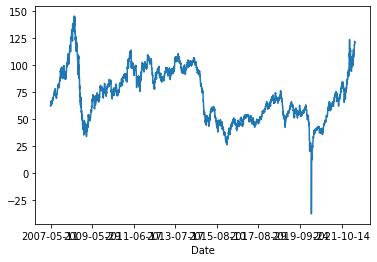

In [8]:
cl_df.close.plot();

In [9]:
sc = StandardScaler()
cols, cl_index = cl_df.columns, cl_df.index
cl_df = pd.DataFrame(sc.fit_transform(cl_df), columns=cols, index=cl_index)
window_size = 21
training_portion = 0.8
episodes = 300

train_cl_df = cl_df[0:int(np.floor(len(cl_df) * training_portion))]
test_cl_df = cl_df[int(np.floor(len(cl_df) * training_portion)):]

env = FuturesEnv(df=train_cl_df,
                 window_size=window_size,
                 frame_bound=(window_size, len(train_cl_df)))

# Training

Only 80% of the total data is used during the training phase. That's because we want to avoid the model simply memorizing the dataset (overfitting) and obtaining a model that is generalized well in all market situations.

The A2C model is a fully connected neural network with 4 layers with 256, 128, 128, 64 neurson respectvely, the neural network will be given as input the daily data of the previous month (21 days).

In [10]:
policy_kwargs = {'net_arch':[256, 128, 128, 64]}
model = DQN("MlpPolicy", 
            env, 
            verbose=1,
            seed=0,
            train_freq=5,
            exploration_final_eps=0.1,
            exploration_fraction=0.35,
            policy_kwargs=policy_kwargs
            )
model.learn(total_timesteps=episodes*len(cl_df))

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.91e+03 |
|    ep_rew_mean      | -6.32    |
|    exploration_rate | 0.973    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5221     |
|    time_elapsed     | 2        |
|    total_timesteps  | 11624    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.91e+03 |
|    ep_rew_mean      | -6.48    |
|    exploration_rate | 0.946    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6801     |
|    time_elapsed     | 3        |
|    total_timesteps  | 23248    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.91e+03 |
|    ep_rew_mean      | 7.5   

# Testing Results

Now that the model has been trained, let's test its performance on the testing data (out of sample data).

In [11]:
testing_env = FuturesEnv(df=test_cl_df,
                 window_size=window_size,
                 frame_bound=(window_size, len(test_cl_df)))

In [12]:
obs = testing_env.reset()
i = 0

for i in range(1000):
    action, _states = model.predict(obs, deterministic=False)
    obs, rewards, dones, info = testing_env.step(action)

    print(f'step: {i}, reward: {rewards}, account_value: {testing_env.get_account_value()}, action: {action}, position: {info["position"]}')

    if dones:
      break

    i += 1

step: 0, reward: 0, account_value: 1000000, action: 1, position: -1
step: 1, reward: -0.05091026213379323, account_value: 1000000, action: 1, position: -1
step: 2, reward: -0.19451114426483523, account_value: 1000000, action: 1, position: -1
step: 3, reward: -0.2502566252767778, account_value: 1000000, action: 1, position: -1
step: 4, reward: -0.3344001866922833, account_value: 1000000, action: 1, position: -1
step: 5, reward: -0.31401870592553166, account_value: 1000000, action: 1, position: -1
step: 6, reward: -0.2857654423578625, account_value: 1000000, action: 1, position: -1
step: 7, reward: -0.25090189532880725, account_value: 1000000, action: 1, position: -1
step: 8, reward: -0.30672489957018245, account_value: 1000000, action: 1, position: -1
step: 9, reward: -0.2981476706445037, account_value: 1000000, action: 1, position: -1
step: 10, reward: -0.2870105873892981, account_value: 1000000, action: 1, position: -1
step: 11, reward: -0.24443038107836637, account_value: 1000000, ac

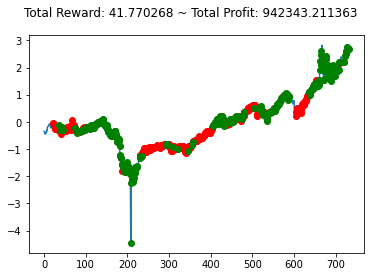

In [13]:
plt.cla()
testing_env.render_all()